# Import Libraries

In [1]:
# from utils import * # backend file
# from dotenv import load_dotenv # load config
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.covariance import ShrunkCovariance,\
	empirical_covariance, log_likelihood
from scipy import linalg
from sklearn.model_selection import GridSearchCV
import random
from sklearn.preprocessing import QuantileTransformer
from pypfopt import black_litterman, risk_models, \
    BlackLittermanModel, plotting, DiscreteAllocation, \
    EfficientFrontier, objective_functions
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from joblib import dump, load
from scipy.stats import linregress
from scipy.optimize import minimize
import yfinance as yf
import pandas as pd
import numpy as np

# Fetching Stocks' Adjusted close Price and Market Cap

In [2]:
tickers_dict = {
    "stocks": ["AAPL", "NVDA", "ORCL", "MSFT", "GOOGL", "META", "AMZN", "TM"], 
    "etfs": ["VTI", "IVV", "VOO", "VGT", "VUG", "XLK"],
    "cash_equivalents": ['SHV', 'BIL']
}

In [3]:
def yfinance_adj_close(tickers, start=None, end=None, period='1mo', interval='1d'):
    if isinstance(tickers, str):
        tickers = [tickers]

    try:
        if start and end:
            print(f"Fetching data for {tickers} from {start} to {end} with interval '{interval}'")
            data = yf.download(tickers, start=start, end=end, interval=interval)
        else:
            print(f"Fetching data for {tickers} with period '{period}' and interval '{interval}'")
            data = yf.download(tickers, period=period, interval=interval)
        
        if "Adj Close" in data.columns:
            return data["Adj Close"]
        else:
            print("Warning: 'Adj Close' data not available, returning full dataset.")
        return data
    except Exception as e:
        print(f"Error while fetching data: {e}")
        return None

In [4]:
all_data = {}
start_date = '2019-01-01'
end_date = '2024-01-01'

for category, tickers in tickers_dict.items():
    print(f"Fetching data for category: {category}")
    all_data[category] = yfinance_adj_close(tickers, start=start_date, end=end_date)

df = pd.concat(all_data.values(), axis=1)
df.ffill(inplace=True)
df.bfill(inplace=True)
df

Fetching data for category: stocks
Fetching data for ['AAPL', 'NVDA', 'ORCL', 'MSFT', 'GOOGL', 'META', 'AMZN', 'TM'] from 2019-01-01 to 2024-01-01 with interval '1d'


[*********************100%***********************]  8 of 8 completed


Fetching data for category: etfs
Fetching data for ['VTI', 'IVV', 'VOO', 'VGT', 'VUG', 'XLK'] from 2019-01-01 to 2024-01-01 with interval '1d'


[*********************100%***********************]  6 of 6 completed


Fetching data for category: cash_equivalents
Fetching data for ['SHV', 'BIL'] from 2019-01-01 to 2024-01-01 with interval '1d'


[*********************100%***********************]  2 of 2 completed


Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA,ORCL,TM,IVV,VGT,VOO,VTI,VUG,XLK,BIL,SHV
Date,,,,,,,,,,,,,,,,
2019-01-02,37.708591,76.956497,52.603748,135.272705,95.310539,3.378323,41.159885,116.279999,228.721680,158.526016,209.174622,116.516754,128.900208,58.594608,80.134155,96.215027
2019-01-03,33.952545,75.014000,51.146851,131.344528,91.804260,3.174214,40.759373,114.650002,223.006332,150.691315,204.181534,113.816582,124.955170,55.637478,80.160431,96.249893
2019-01-04,35.401955,78.769501,53.770355,137.535889,96.074020,3.377579,42.516090,119.730003,230.847900,157.243958,210.920868,117.584023,129.927277,58.103325,80.169205,96.276070
2019-01-07,35.323158,81.475502,53.663120,137.635590,96.196548,3.556390,43.189655,121.279999,232.401672,159.000809,212.503403,118.769897,131.251892,58.622959,80.169205,96.276070
2019-01-08,35.996521,82.829002,54.134453,142.102158,96.894028,3.467853,43.581051,122.309998,234.691376,160.529739,214.567947,119.992271,132.854874,59.114239,80.169205,96.267380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,192.656174,153.419998,141.140518,352.329193,371.799713,48.819527,104.916985,178.529999,471.056519,481.073242,431.015472,234.245361,309.418091,191.054443,87.204689,105.034897
2023-12-26,192.108871,153.410004,141.170441,353.764832,371.879150,49.268425,104.907104,179.850006,473.085999,483.450745,432.807709,235.403564,310.523987,191.850296,87.223793,105.054008
2023-12-27,192.208359,153.339996,140.023270,356.755859,371.293518,49.406395,104.660126,180.720001,473.986877,483.918274,433.599854,235.849030,310.872681,191.840332,87.223793,105.054008


In [5]:
all_caps = {}
start_date = '2019-01-01'
end_date = '2024-01-01'

for category, tickers in tickers_dict.items():
    if category == 'cash_equivalents':
        continue
    
    print(f"Fetching marketCap data for category: {category}")
    market_caps = {}
    
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        data = stock.history(start=start_date, end=end_date)
        
        outstanding_shares = stock.info.get('sharesOutstanding', None)
        
        if outstanding_shares is not None:
            market_cap_series = data['Close'] * outstanding_shares
            market_caps[ticker] = market_cap_series
        else:
            print(f"Warning: {ticker} has no outstanding shares data.")
            market_caps[ticker] = pd.Series([None] * len(data), index=data.index)
    
    all_caps[category] = pd.DataFrame(market_caps)

caps = pd.concat(all_caps.values(), axis=1)
caps.ffill(inplace=True)
caps.bfill(inplace=True)
caps

Fetching marketCap data for category: stocks
Fetching marketCap data for category: etfs


,AAPL,NVDA,ORCL,MSFT,GOOGL,META,AMZN,TM,VTI,IVV,VOO,VGT,VUG,XLK
Date,,,,,,,,,,,,,,
2019-01-02 00:00:00-05:00,5.699955e+11,8.273513e+10,1.140565e+11,7.086224e+11,3.073637e+11,2.948945e+11,8.091976e+11,1.526756e+11,None,None,None,None,None,None
2019-01-03 00:00:00-05:00,5.132199e+11,7.773650e+10,1.129467e+11,6.825537e+11,2.988510e+11,2.863311e+11,7.887722e+11,1.505354e+11,None,None,None,None,None,None
2019-01-04 00:00:00-05:00,5.351289e+11,8.271692e+10,1.178146e+11,7.142988e+11,3.141802e+11,2.998282e+11,8.282613e+11,1.572055e+11,None,None,None,None,None,None
2019-01-07 00:00:00-05:00,5.339378e+11,8.709599e+10,1.196811e+11,7.152098e+11,3.135536e+11,3.000456e+11,8.567149e+11,1.592406e+11,None,None,None,None,None,None
2019-01-08 00:00:00-05:00,5.441162e+11,8.492772e+10,1.207657e+11,7.203955e+11,3.163076e+11,3.097827e+11,8.709470e+11,1.605930e+11,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22 00:00:00-05:00,2.912152e+12,1.195590e+12,2.907313e+11,2.764286e+12,8.246840e+11,7.680776e+11,1.613211e+12,2.344099e+11,None,None,None,None,None,None
2023-12-26 00:00:00-05:00,2.903879e+12,1.206584e+12,2.907039e+11,2.764877e+12,8.248589e+11,7.712073e+11,1.613106e+12,2.361430e+11,None,None,None,None,None,None
2023-12-27 00:00:00-05:00,2.905383e+12,1.209963e+12,2.900195e+11,2.760523e+12,8.181559e+11,7.777278e+11,1.612370e+12,2.372854e+11,None,None,None,None,None,None


In [6]:
caps_dict = {
    'AAPL': 2.67e12,  # Apple Inc. (~2.67 trillion)
    'NVDA': 1.07e12,  # NVIDIA Corporation (~1.07 trillion)
    'ORCL': 3.05e11,  # Oracle Corporation (~305 billion)
    'MSFT': 2.48e12,  # Microsoft Corporation (~2.48 trillion)
    'GOOGL': 1.56e12, # Alphabet Inc. (Google) (~1.56 trillion)
    'META': 8.99e11,  # Meta Platforms, Inc. (~899 billion)
    'AMZN': 1.08e12,  # Amazon.com, Inc. (~1.08 trillion)
    'TM': 2.69e11,    # Toyota Motor Corporation (~269 billion)
    'VTI': 1.3e11,    # Vanguard Total Stock Market ETF (~130 billion)
    'IVV': 3.9e10,    # iShares Core S&P 500 ETF (~39 billion)
    'VOO': 3.4e11,    # Vanguard S&P 500 ETF (~340 billion)
    'VGT': 2.5e11,    # Vanguard Information Technology ETF (~250 billion)
    'VUG': 5.5e10,    # Vanguard Growth ETF (~55 billion)
    'XLK': 3.0e11     # Technology Select Sector SPDR Fund (~300 billion)
}

caps_dict

{'AAPL': 2670000000000.0,
 'NVDA': 1070000000000.0,
 'ORCL': 305000000000.0,
 'MSFT': 2480000000000.0,
 'GOOGL': 1560000000000.0,
 'META': 899000000000.0,
 'AMZN': 1080000000000.0,
 'TM': 269000000000.0,
 'VTI': 130000000000.0,
 'IVV': 39000000000.0,
 'VOO': 340000000000.0,
 'VGT': 250000000000.0,
 'VUG': 55000000000.0,
 'XLK': 300000000000.0}

In [7]:
ticker = "^IRX"

start_date = "2019-01-01"
end_date = "2024-01-01"

rf = yf.download(ticker, start=start_date, end=end_date)
rf = rf[['Adj Close']]
rf = rf.rename(columns={'Adj Close': 'rf'})
rf

[*********************100%***********************]  1 of 1 completed


Price,rf
Ticker,^IRX
Date,
2019-01-02,2.365
2019-01-03,2.355
2019-01-04,2.358
2019-01-07,2.353
2019-01-08,2.400
...,...
2023-12-22,5.208
2023-12-26,5.203


In [8]:
rolling_rf = rf.rolling(window=252).mean()
rolling_rf

Price,rf
Ticker,^IRX
Date,
2019-01-02,NaN
2019-01-03,NaN
2019-01-04,NaN
2019-01-07,NaN
2019-01-08,NaN
...,...
2023-12-22,5.023583
2023-12-26,5.027532


# VCV Matrix 

In [9]:
selected_tickers = tickers_dict['stocks'] + tickers_dict['etfs']

filtered_df = df[selected_tickers]
filtered_df

Ticker,AAPL,NVDA,ORCL,MSFT,GOOGL,META,AMZN,TM,VTI,IVV,VOO,VGT,VUG,XLK
Date,,,,,,,,,,,,,,
2019-01-02,37.708591,3.378323,41.159885,95.310539,52.603748,135.272705,76.956497,116.279999,116.516754,228.721680,209.174622,158.526016,128.900208,58.594608
2019-01-03,33.952545,3.174214,40.759373,91.804260,51.146851,131.344528,75.014000,114.650002,113.816582,223.006332,204.181534,150.691315,124.955170,55.637478
2019-01-04,35.401955,3.377579,42.516090,96.074020,53.770355,137.535889,78.769501,119.730003,117.584023,230.847900,210.920868,157.243958,129.927277,58.103325
2019-01-07,35.323158,3.556390,43.189655,96.196548,53.663120,137.635590,81.475502,121.279999,118.769897,232.401672,212.503403,159.000809,131.251892,58.622959
2019-01-08,35.996521,3.467853,43.581051,96.894028,54.134453,142.102158,82.829002,122.309998,119.992271,234.691376,214.567947,160.529739,132.854874,59.114239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,192.656174,48.819527,104.916985,371.799713,141.140518,352.329193,153.419998,178.529999,234.245361,471.056519,431.015472,481.073242,309.418091,191.054443
2023-12-26,192.108871,49.268425,104.907104,371.879150,141.170441,353.764832,153.410004,179.850006,235.403564,473.085999,432.807709,483.450745,310.523987,191.850296
2023-12-27,192.208359,49.406395,104.660126,371.293518,140.023270,356.755859,153.339996,180.720001,235.849030,473.986877,433.599854,483.918274,310.872681,191.840332


In [10]:
def return_from_prices(prices, log_returns = False):
    if log_returns:
        returns = np.log(1 + prices.pct_change()).dropna(how = 'all')
    else:
        returns = prices.pct_change().dropna(how = 'all')
    return returns

In [11]:
log_returns = return_from_prices(filtered_df, log_returns=True)
log_returns.dropna(inplace=True)
log_returns

Ticker,AAPL,NVDA,ORCL,MSFT,GOOGL,META,AMZN,TM,VTI,IVV,VOO,VGT,VUG,XLK
Date,,,,,,,,,,,,,,
2019-01-03,-0.104924,-0.062319,-0.009778,-0.037482,-0.028086,-0.029469,-0.025566,-0.014117,-0.023447,-0.025306,-0.024160,-0.050685,-0.031083,-0.051786
2019-01-04,0.041803,0.062099,0.042197,0.045460,0.050021,0.046061,0.048851,0.043355,0.032565,0.034559,0.032474,0.042565,0.039020,0.043366
2019-01-07,-0.002228,0.051587,0.015718,0.001275,-0.001996,0.000725,0.033777,0.012863,0.010035,0.006708,0.007475,0.011111,0.010143,0.008904
2019-01-08,0.018884,-0.025210,0.009021,0.007224,0.008745,0.031937,0.016476,0.008457,0.010239,0.009804,0.009668,0.009570,0.012139,0.008345
2019-01-09,0.016839,0.019476,-0.002091,0.014198,-0.003433,0.011857,0.001713,0.004975,0.004702,0.004635,0.004609,0.012405,0.007772,0.012862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,-0.005563,-0.003271,0.003207,0.002780,0.007591,-0.001979,-0.002734,-0.012967,0.002285,0.001914,0.002323,0.000972,-0.000097,0.001303
2023-12-26,-0.002845,0.009153,-0.000094,0.000214,0.000212,0.004066,-0.000065,0.007367,0.004932,0.004299,0.004150,0.004930,0.003568,0.004157
2023-12-27,0.000518,0.002796,-0.002357,-0.001576,-0.008159,0.008419,-0.000456,0.004826,0.001891,0.001902,0.001829,0.000967,0.001122,-0.000052


In [12]:
scaler = QuantileTransformer(output_distribution='uniform')
scaled_df = pd.DataFrame(scaler.fit_transform(filtered_df), columns=filtered_df.columns, index=filtered_df.index)

print(scaled_df)

Ticker          AAPL      NVDA      ORCL      MSFT     GOOGL      META  \
Date                                                                     
2019-01-02  0.014024  0.003772  0.003038  0.000948  0.005029  0.055055   
2019-01-03  0.000000  0.000000  0.001820  0.000000  0.000000  0.046069   
2019-01-04  0.001215  0.003592  0.006165  0.001908  0.011977  0.061565   
2019-01-07  0.000986  0.011131  0.008805  0.003006  0.010682  0.062031   
2019-01-08  0.003101  0.007106  0.011374  0.005005  0.021488  0.070027   
...              ...       ...       ...       ...       ...       ...   
2023-12-22  0.987993  0.987274  0.905959  0.991224  0.939572  0.961021   
2023-12-26  0.980967  0.991348  0.905529  0.991999  0.940213  0.965656   
2023-12-27  0.982600  0.993676  0.903547  0.987555  0.927712  0.971284   
2023-12-28  0.987667  0.995996  0.906957  0.992803  0.926044  0.972943   
2023-12-29  0.978722  0.995996  0.899817  0.993907  0.920806  0.962805   

Ticker          AMZN        TM       

## Train the model using RandomForest 

In [13]:
base_X_train = scaled_df.loc[:'2021-01-01']
base_X_test = scaled_df.loc['2021-01-01':]

In [14]:
noOfFeatures, noOfSamples = 14, 1489
np.random.seed(42)

colorMatrix = np.random.randn(noOfFeatures, noOfFeatures)
X_train = np.dot(base_X_train, colorMatrix)
X_test = np.dot(base_X_test, colorMatrix)

In [15]:
# defining a Spanning range of all possible shrinkage coefficient values
shrinkageFactor = np.logspace(-2, 0, 32)
negative_logliks = [
	-ShrunkCovariance(shrinkage=s).fit(X_train).score(X_test)\
for s in shrinkageFactor]
realCovariance = np.dot(colorMatrix.T, colorMatrix)
empiricalCovariance = empirical_covariance(X_train)
logRealLikelihood = - \
	log_likelihood(empiricalCovariance, linalg.inv(realCovariance))

# GridSearch method for an optimal shrinkage coefficient
tunedParameters = [{"shrinkage": shrinkageFactor}]
cv = GridSearchCV(ShrunkCovariance(), tunedParameters)
cv.fit(X_train)

GridSearchCV(estimator=ShrunkCovariance(),
             param_grid=[{'shrinkage': array([0.01      , 0.01160155, 0.0134596 , 0.01561523, 0.01811609,
       0.02101748, 0.02438354, 0.02828869, 0.03281928, 0.03807546,
       0.04417345, 0.05124806, 0.05945571, 0.06897785, 0.08002502,
       0.09284145, 0.10771051, 0.12496091, 0.14497407, 0.16819243,
       0.19512934, 0.22638034, 0.26263635, 0.30469896, 0.35349811,
       0.41011271, 0.47579443, 0.55199543, 0.64040043, 0.74296395,
       0.86195357, 1.        ])}])

In [16]:
optimal_shrinkage_coef = cv.best_estimator_.shrinkage
optimal_shrinkage_coef

0.021017480113324882

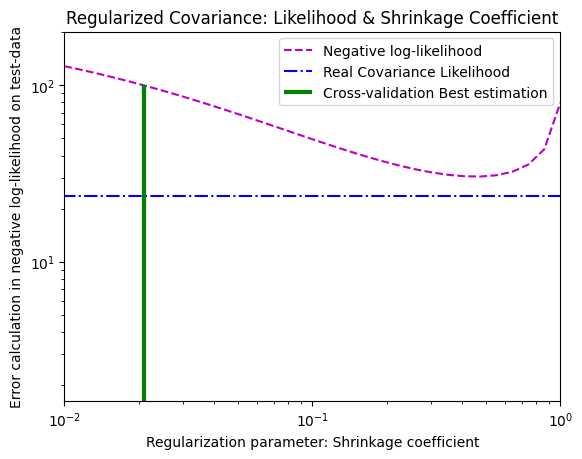

In [17]:
# defining range of shrinkage curve
plt.loglog(shrinkageFactor,
		negative_logliks,
		"m--",
		label="Negative log-likelihood")

plt.plot(plt.xlim(),
		2 * [logRealLikelihood],
		"b-.",
		label="Real Covariance Likelihood")

# Adjusting View in Graph
maxLikelihood = np.amax(negative_logliks)
minLikelihood = np.amin(negative_logliks)
min_y = minLikelihood - 7.0 * np.log((plt.ylim()[1] - plt.ylim()[0]))
max_y = maxLikelihood + 16.0 * np.log(maxLikelihood - minLikelihood)
min_x = shrinkageFactor[0]
max_x = shrinkageFactor[-1]

# Best Covariance estimator likelihood
plt.vlines(
	cv.best_estimator_.shrinkage, min_y,
	-cv.best_estimator_.score(X_test),
	color="green",
	linewidth=3,
	label="Cross-validation Best estimation",
)
#plotting in Graph
plt.title("Regularized Covariance: Likelihood & Shrinkage Coefficient")
plt.xlabel("Regularization parameter: Shrinkage coefficient")
plt.ylabel("Error calculation in negative log-likelihood on test-data")
plt.ylim(min_y, max_y)
plt.xlim(min_x, max_x)
plt.legend()
plt.show()

In [18]:
from pypfopt.risk_models import CovarianceShrinkage

class CustomCovarianceShrinkage(CovarianceShrinkage):
    def shrunk_covariance(self, delta=0.2):
        return super().shrunk_covariance(delta=optimal_shrinkage_coef)
    
cov_matrix = CustomCovarianceShrinkage(log_returns, True, 252, True).ledoit_wolf()
cov_matrix

Ticker,AAPL,NVDA,ORCL,MSFT,GOOGL,META,AMZN,TM,VTI,IVV,VOO,VGT,VUG,XLK
Ticker,,,,,,,,,,,,,,
AAPL,0.103867,0.109179,0.049460,0.073988,0.068803,0.082730,0.069699,0.033213,0.054695,0.054957,0.054792,0.077115,0.067696,0.077426
NVDA,0.109179,0.263344,0.070828,0.110732,0.102858,0.123949,0.109322,0.051019,0.079271,0.078021,0.077885,0.115739,0.101944,0.114067
ORCL,0.049460,0.070828,0.093764,0.052599,0.045163,0.049170,0.042314,0.030709,0.041014,0.041410,0.041472,0.051443,0.045249,0.052042
MSFT,0.073988,0.110732,0.052599,0.093041,0.073006,0.082176,0.072693,0.032138,0.052993,0.053331,0.053260,0.074604,0.066772,0.075231
GOOGL,0.068803,0.102858,0.045163,0.073006,0.101265,0.092532,0.073389,0.032265,0.051319,0.051204,0.051122,0.067755,0.064234,0.067412
META,0.082730,0.123949,0.049170,0.082176,0.092532,0.194693,0.094085,0.033969,0.058812,0.058140,0.058106,0.079975,0.077012,0.078863
AMZN,0.069699,0.109322,0.042314,0.072693,0.073389,0.094085,0.123634,0.029385,0.048572,0.048134,0.048021,0.068203,0.066009,0.066844
TM,0.033213,0.051019,0.030709,0.032138,0.032265,0.033969,0.029385,0.056079,0.030431,0.030091,0.030038,0.034658,0.031965,0.034537
VTI,0.054695,0.079271,0.041014,0.052993,0.051319,0.058812,0.048572,0.030431,0.047466,0.045671,0.045570,0.055269,0.050979,0.054773


In [19]:
target_prices = pd.read_excel(r"/Users/anhpham/Downloads/FIN2/MIDTERM/target_prices.xlsx", sheet_name="Sheet1", index_col=0)
target_prices = target_prices[['target_prices']]
columns_to_select = filtered_df.columns
target_prices = target_prices[target_prices.index.isin(columns_to_select)]
target_series = target_prices['target_prices']
target_series

tickers
AAPL     105.56
NVDA     125.67
ORCL     156.12
MSFT     369.79
GOOGL    162.45
META     391.22
AMZN     212.94
TM       151.98
VTI      300.41
IVV      606.90
VOO      555.54
VGT      456.70
VUG      405.67
XLK      235.55
Name: target_prices, dtype: float64

In [20]:
start_date = '2019-01-01'
end_date = '2024-01-01'

market_prices = yf.download("SPY", start=start_date, end=end_date)["Adj Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Ticker,SPY
Date,
2019-01-02,228.403625
2019-01-03,222.953293
2019-01-04,230.421265
2019-01-07,232.238052
2019-01-08,234.420029


In [21]:
market_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2019-01-02 to 2023-12-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPY     1258 non-null   float64
dtypes: float64(1)
memory usage: 19.7 KB


## Covariance and Correlation Matrices

In [22]:
S = cov_matrix
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

3.793471129015463

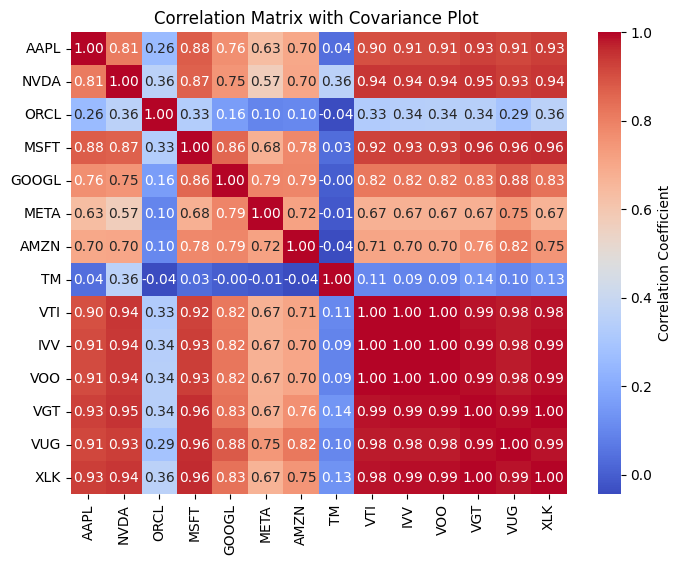

In [23]:
corr_matrix = np.corrcoef(S)

plt.figure(figsize=(8, 6))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', 
            xticklabels=S.columns, yticklabels=S.columns,
            cbar_kws={'label': 'Correlation Coefficient'});

plt.title("Correlation Matrix with Covariance Plot ")
plt.show()

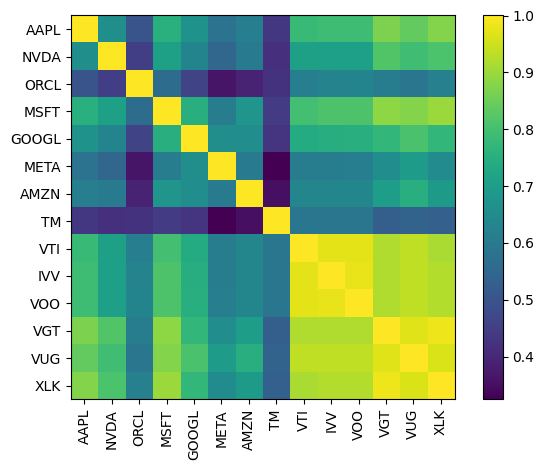

In [24]:
plotting.plot_covariance(S, plot_correlation=True);

## BlackLitterman Model

In [25]:
market_prior = black_litterman.market_implied_prior_returns(caps_dict, delta, S)
market_prior

Ticker
AAPL     0.309108
NVDA     0.457913
ORCL     0.194699
MSFT     0.301471
GOOGL    0.293098
META     0.357903
AMZN     0.298920
TM       0.131284
VTI      0.207074
IVV      0.206538
VOO      0.206263
VGT      0.286316
VUG      0.259882
XLK      0.285455
dtype: float64

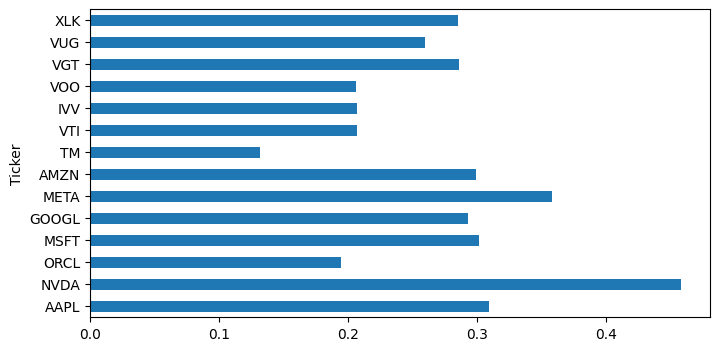

In [26]:
market_prior.plot.barh(figsize=(8,4));

In [27]:
last_row = filtered_df.iloc[-1]
sorted_target = target_series.reindex(last_row.index)
expt_returns = (sorted_target - last_row) / last_row
expt_returns.to_dict()

{'AAPL': -0.4490357692133398,
 'NVDA': 1.5382045825946464,
 'ORCL': 0.49890145101381694,
 'MSFT': -0.009267010176098949,
 'GOOGL': 0.1658118478848975,
 'META': 0.1085939778673759,
 'AMZN': 0.401474243638489,
 'TM': -0.17122916374049846,
 'VTI': 0.279269083768579,
 'IVV': 0.28349808213293454,
 'VOO': 0.28445400912809493,
 'VGT': -0.05142941825648151,
 'VUG': 0.309808587354159,
 'XLK': 0.2301404967114053}

In [28]:
viewdict = expt_returns
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

In [29]:
def calculate_confidence(views):
    if abs(views) > 0.3:
        return random.choice([0.7, 0.8, 0.9])
    elif abs(views) > 0.1:
        return random.choice([0.4, 0.5, 0.6])
    else:
        return random.choice([0.1, 0.2, 0.3])
    
confidences = {ticker: calculate_confidence(return_value) for ticker, return_value in viewdict.items()}
confidences = list(confidences.values())
print(confidences)

[0.7, 0.8, 0.9, 0.1, 0.5, 0.4, 0.8, 0.5, 0.4, 0.5, 0.6, 0.2, 0.7, 0.4]


In [30]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

In [31]:
np.diag(bl.omega)

array([0.00222571, 0.0032918 , 0.00052091, 0.04186832, 0.00506324,
       0.01460196, 0.00154542, 0.00280397, 0.00355996, 0.00232061,
       0.00154048, 0.01525283, 0.00134262, 0.00565468])

In [32]:
intervals = []
for confidence in confidences:
    if confidence >= 0.7:
        interval = (confidence - 0.1, confidence + 0.1)
    elif 0.4 <= confidence <= 0.6:
        interval = (confidence - 0.05, confidence + 0.05)
    else:
        interval = (confidence - 0.03, confidence + 0.03)
    
    interval = (max(0, interval[0]), min(1, interval[1]))
    intervals.append(interval)

In [33]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.009999999999999995, 0.009999999999999995, 0.009999999999999995, 0.0009, 0.002500000000000002, 0.0024999999999999988, 0.009999999999999995, 0.002500000000000002, 0.0024999999999999988, 0.002500000000000002, 0.0025000000000000044, 0.0009, 0.009999999999999995, 0.0024999999999999988]


In [34]:
bl = BlackLittermanModel(S, pi="market", market_caps=caps_dict, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [35]:
ret_bl = bl.bl_returns()
ret_bl

Ticker
AAPL     0.063088
NVDA     0.622025
ORCL     0.171947
MSFT     0.072593
GOOGL    0.156571
META     0.147025
AMZN     0.207434
TM      -0.003437
VTI      0.135529
IVV      0.130505
VOO      0.130506
VGT      0.138066
VUG      0.149465
XLK      0.143869
dtype: float64

## Returns using BlackLitterman Model

In [36]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
Ticker,,,
AAPL,0.309108,0.063088,-0.449036
NVDA,0.457913,0.622025,1.538205
ORCL,0.194699,0.171947,0.498901
MSFT,0.301471,0.072593,-0.009267
GOOGL,0.293098,0.156571,0.165812
META,0.357903,0.147025,0.108594
AMZN,0.298920,0.207434,0.401474
TM,0.131284,-0.003437,-0.171229
VTI,0.207074,0.135529,0.279269


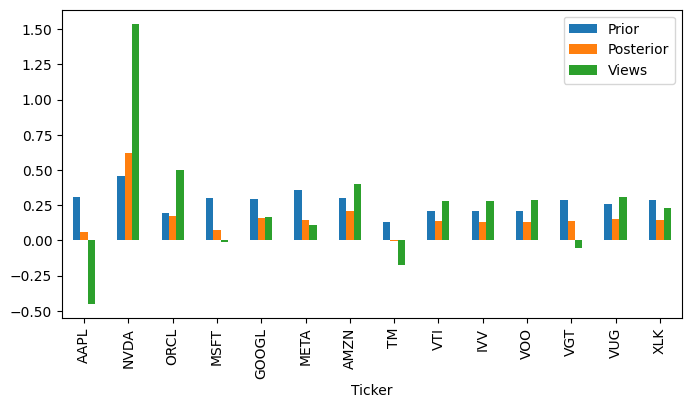

In [37]:
rets_df.plot.bar(figsize=(8,4));

In [38]:
S_bl = bl.bl_cov()

In [39]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_constraint(lambda w: w >= 0.0)
ef.add_constraint(lambda w: w <= 0.10)
bond_etfs = [0, 1, 2, 3, 4, 5, 6, 7]
stock_etfs = [8, 9, 10, 11, 12, 13]
ef.add_constraint(lambda w: sum(w[i] for i in bond_etfs) >= 0.6)
ef.add_constraint(lambda w: sum(w[i] for i in stock_etfs) <= 0.3)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.06996),
             ('NVDA', 0.1),
             ('ORCL', 0.1),
             ('MSFT', 0.07789),
             ('GOOGL', 0.1),
             ('META', 0.1),
             ('AMZN', 0.1),
             ('TM', 0.05215),
             ('VTI', 0.05574),
             ('IVV', 0.05194),
             ('VOO', 0.05202),
             ('VGT', 0.03993),
             ('VUG', 0.05524),
             ('XLK', 0.04514)])

In [40]:
da = DiscreteAllocation(weights, filtered_df.iloc[-1], total_portfolio_value=400000)
alloc, leftover = da.greedy_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $44.53


{'NVDA': 807,
 'ORCL': 384,
 'GOOGL': 287,
 'META': 113,
 'AMZN': 263,
 'MSFT': 84,
 'AAPL': 146,
 'VTI': 95,
 'VUG': 71,
 'TM': 114,
 'VOO': 48,
 'IVV': 44,
 'XLK': 95,
 'VGT': 33}

## Optimal Portfolio Theory regression

In [41]:
stock_list = list(weights.keys())
stock_weights = list(weights.values())
portfolio = filtered_df[stock_list]
portfolio = np.log(portfolio / portfolio.shift(1))
portfolio.dropna(inplace=True)
portfolio

Ticker,AAPL,NVDA,ORCL,MSFT,GOOGL,META,AMZN,TM,VTI,IVV,VOO,VGT,VUG,XLK
Date,,,,,,,,,,,,,,
2019-01-03,-0.104924,-0.062319,-0.009778,-0.037482,-0.028086,-0.029469,-0.025566,-0.014117,-0.023447,-0.025306,-0.024160,-0.050685,-0.031083,-0.051786
2019-01-04,0.041803,0.062099,0.042197,0.045460,0.050021,0.046061,0.048851,0.043355,0.032565,0.034559,0.032474,0.042565,0.039020,0.043366
2019-01-07,-0.002228,0.051587,0.015718,0.001275,-0.001996,0.000725,0.033777,0.012863,0.010035,0.006708,0.007475,0.011111,0.010143,0.008904
2019-01-08,0.018884,-0.025210,0.009021,0.007224,0.008745,0.031937,0.016476,0.008457,0.010239,0.009804,0.009668,0.009570,0.012139,0.008345
2019-01-09,0.016839,0.019476,-0.002091,0.014198,-0.003433,0.011857,0.001713,0.004975,0.004702,0.004635,0.004609,0.012405,0.007772,0.012862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,-0.005563,-0.003271,0.003207,0.002780,0.007591,-0.001979,-0.002734,-0.012967,0.002285,0.001914,0.002323,0.000972,-0.000097,0.001303
2023-12-26,-0.002845,0.009153,-0.000094,0.000214,0.000212,0.004066,-0.000065,0.007367,0.004932,0.004299,0.004150,0.004930,0.003568,0.004157
2023-12-27,0.000518,0.002796,-0.002357,-0.001576,-0.008159,0.008419,-0.000456,0.004826,0.001891,0.001902,0.001829,0.000967,0.001122,-0.000052


In [42]:
weights_series = pd.Series(weights)
weighted_returns = portfolio.mul(weights_series, axis=1)
portfolio_returns = weighted_returns.sum(axis=1)


In [53]:
def get_factors(factors):
    factor_file = factors + ".csv"
    factor_df = pd.read_csv(factor_file)

    # Rename the first column to 'Date'
    factor_df = factor_df.rename(columns={'Unnamed: 0': 'Date'})

    # Check if the date format is monthly or daily
    if len(str(factor_df['Date'].iloc[0])) == 6:  # YYYYMM format (monthly)
        # Convert the date to YYYY-MM format
        factor_df['Date'] = factor_df['Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m').strftime('%Y-%m'))
    else:  # Assuming YYYYMMDD format (daily)
        factor_df['Date'] = factor_df['Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

    # Set the 'Date' column as the index
    factor_df = factor_df.set_index('Date')

    return factor_df

In [54]:
ff_factors_monthly = get_factors("F-F_Research_Data_Factors_daily.csv")
ff_factors_monthly.head()

FileNotFoundError: [Errno 2] No such file or directory: 'F-F_Research_Data_Factors_daily.csv.csv'

In [ ]:
ff_factors_subset = ff_factors_monthly[
    ff_factors_monthly.index.isin(portfolio_returns.index)
].copy()

# Step 3: Calculate excess returns for the asset
ff_factors_subset["Excess_Return"] = portfolio_returns - ff_factors_subset["RF"]
ff_factors_subset

,Mkt-RF,SMB,HML,RF,Excess_Return
Date,,,,,
2019-01-03,-2.45,0.36,1.20,0.010,-0.046475
2019-01-04,3.55,0.41,-0.70,0.010,0.034761
2019-01-07,0.94,1.00,-0.75,0.010,0.003298
2019-01-08,1.01,0.53,-0.63,0.010,-0.000566
2019-01-09,0.56,0.45,0.10,0.010,-0.002456
...,...,...,...,...,...
2023-12-22,0.20,0.64,0.10,0.021,-0.021128
2023-12-26,0.48,0.71,0.43,0.021,-0.018175
2023-12-27,0.16,0.14,0.10,0.021,-0.020413


In [ ]:
X = sm.add_constant(ff_factors_subset[["Mkt-RF", "SMB", "HML"]])
y = ff_factors_subset["Excess_Return"]
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Excess_Return   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     1459.
Date:                Wed, 04 Dec 2024   Prob (F-statistic):               0.00
Time:                        21:22:55   Log-Likelihood:                 4193.9
No. Observations:                1257   AIC:                            -8380.
Df Residuals:                    1253   BIC:                            -8359.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0067      0.000    -27.627      0.0

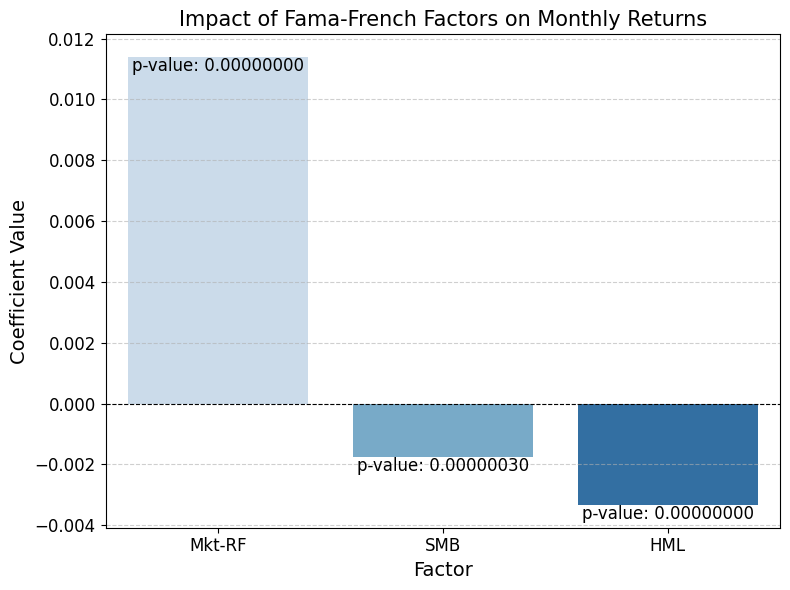

In [ ]:
factors = model.params.index[1:]  # ['Mkt_Rf', 'SMB', 'HML']
coefficients = model.params.values[1:]
confidence_intervals = model.conf_int().diff(axis=1).iloc[1]

ols_data = pd.DataFrame(
    {
        "Factor": factors,
        "Coefficient": coefficients,
        "Confidence_Lower": confidence_intervals[0],
        "Confidence_Upper": confidence_intervals[1],
    }
)

plt.figure(figsize=(8, 6))

sns.barplot(x="Factor", y="Coefficient", data=ols_data, palette="Blues")

for i, row in ols_data.iterrows():
    plt.text(
        i,
        row['Coefficient'],
        f"p-value: {model.pvalues[row['Factor']]:.8f}",
        ha="center",
        va="top",
        fontsize=12,
        color="black",
    )

plt.title("Impact of Fama-French Factors on Monthly Returns", fontsize=15)
plt.xlabel("Factor", fontsize=14)
plt.ylabel("Coefficient Value", fontsize=14)

plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

# Scenario Analysis

In [ ]:
from dataclasses import dataclass
from sensitivity import SensitivityAnalyzer

In [ ]:
@dataclass
class ModelInputs:
    starting_salary: int = 60000
    promos_every_n_years: int = 5
    cost_of_living_raise: float = 0.02
    promo_raise: float = 0.15
    savings_rate: float = 0.25
    interest_rate: float = 0.05
    desired_cash: int = 1500000
        
model_data = ModelInputs()
model_data

ModelInputs(starting_salary=60000, promos_every_n_years=5, cost_of_living_raise=0.02, promo_raise=0.15, savings_rate=0.25, interest_rate=0.05, desired_cash=1500000)

In [ ]:
def salary_at_year(data: ModelInputs, year):
    """
    Gets the salary at a given year from the start of the model based on cost of living raises and regular promotions.
    """
    # Every n years we have a promotion, so dividing the years and taking out the decimals gets the number of promotions
    num_promos = int(year / data.promos_every_n_years)
    salary_t = data.starting_salary * (1 + data.cost_of_living_raise) ** year * (1 + data.promo_raise) ** num_promos
    return salary_t

In [ ]:
for i in range(6):
    year = i + 1
    salary = salary_at_year(model_data, year)
    print(f'The salary at year {year} is ${salary:,.0f}.')

The salary at year 1 is $61,200.
The salary at year 2 is $62,424.
The salary at year 3 is $63,672.
The salary at year 4 is $64,946.
The salary at year 5 is $76,182.
The salary at year 6 is $77,705.


In [ ]:
def cash_saved_during_year(data: ModelInputs, year):
    """
    Calculated the cash saved within a given year, by first calculating the salary at that year then applying the 
    savings rate.
    """
    salary = salary_at_year(data, year)
    cash_saved = salary * data.savings_rate
    return cash_saved

In [ ]:
def wealth_at_year(data: ModelInputs, year, prior_wealth):
    """
    Calculate the accumulated wealth for a given year, based on previous wealth, the investment rate,
    and cash saved during the year.
    """
    cash_saved = cash_saved_during_year(data, year)
    wealth = prior_wealth * (1 + data.interest_rate) + cash_saved
    return wealth

In [ ]:
prior_wealth = 120000  # starting with Salary savings $120,000
for i in range(6):
    year = i + 1
    wealth = wealth_at_year(model_data, year, prior_wealth)
    print(f'The wealth at year {year} is ${wealth:,.0f}.')
    
    # Set next year's prior wealth to this year's wealth
    prior_wealth = wealth

The wealth at year 1 is $141,300.
The wealth at year 2 is $163,971.
The wealth at year 3 is $188,088.
The wealth at year 4 is $213,729.
The wealth at year 5 is $243,460.
The wealth at year 6 is $275,060.


In [ ]:
def years_to_retirement(data: ModelInputs, print_output=True):
    
    # starting with no cash saved
    prior_wealth = 0 
    wealth = 0
    
    year = 0
    
    if print_output:
        print('Wealths over time:')
    while wealth < data.desired_cash:
        year = year + 1
        wealth = wealth_at_year(data, year, prior_wealth)
        if print_output:
            print(f'The wealth at year {year} is ${wealth:,.0f}.')

        # Set next year's prior wealth to this year's wealth
        prior_wealth = wealth
        
    # Now we have exited the while loop, so wealth must be >= desired_cash. Whatever last year was set
    # is the years to retirement.
    if print_output:
        print(f'\nRetirement:\nIt will take {year} years to retire.')  # \n makes a blank line in the output.
    return year

In [ ]:
years = years_to_retirement(model_data)

Wealths over time:
The wealth at year 1 is $15,300.
The wealth at year 2 is $31,671.
The wealth at year 3 is $49,173.
The wealth at year 4 is $67,868.
The wealth at year 5 is $90,307.
The wealth at year 6 is $114,248.
The wealth at year 7 is $139,775.
The wealth at year 8 is $166,975.
The wealth at year 9 is $195,939.
The wealth at year 10 is $229,918.
The wealth at year 11 is $266,080.
The wealth at year 12 is $304,542.
The wealth at year 13 is $345,431.
The wealth at year 14 is $388,878.
The wealth at year 15 is $439,025.
The wealth at year 16 is $492,294.
The wealth at year 17 is $548,853.
The wealth at year 18 is $608,878.
The wealth at year 19 is $672,557.
The wealth at year 20 is $745,168.
The wealth at year 21 is $822,190.
The wealth at year 22 is $903,859.
The wealth at year 23 is $990,422.
The wealth at year 24 is $1,082,140.
The wealth at year 25 is $1,185,745.
The wealth at year 26 is $1,295,520.
The wealth at year 27 is $1,411,793.
The wealth at year 28 is $1,534,910.

Reti

In [ ]:
def get_salaries_wealths_df(data):
    """
    Runs the retirement model, collecting salary and wealth information year by year and storing
    into a DataFrame for further analysis.
    """
    # starting with no cash saved
    prior_wealth = 0  
    wealth = 0
    
    year = 0
    
    df_data_tups = []
    while wealth < data.desired_cash:
        year = year + 1
        salary = salary_at_year(data, year)
        wealth = wealth_at_year(data, year, prior_wealth)

        # Set next year's prior wealth to this year's wealth
        prior_wealth = wealth
        df_data_tups.append((year, salary, wealth))
        
    df = pd.DataFrame(df_data_tups, columns=['Year', 'Salary', 'Wealth'])
    
    return df

In [ ]:
def styled_salaries_wealths(df):
    return df.style.format({
        'Salary': '${:,.2f}',
        'Wealth': '${:,.2f}'
    })

In [ ]:
df = get_salaries_wealths_df(model_data)
styled_salaries_wealths(df)

,Year,Salary,Wealth
0,1,"$61,200.00","$15,300.00"
1,2,"$62,424.00","$31,671.00"
2,3,"$63,672.48","$49,172.67"
3,4,"$64,945.93","$67,867.79"
4,5,"$76,181.58","$90,306.57"
5,6,"$77,705.21","$114,248.20"
6,7,"$79,259.31","$139,775.44"
7,8,"$80,844.50","$166,975.33"
8,9,"$82,461.39","$195,939.45"
9,10,"$96,727.21","$229,918.22"


<Axes: xlabel='Year'>

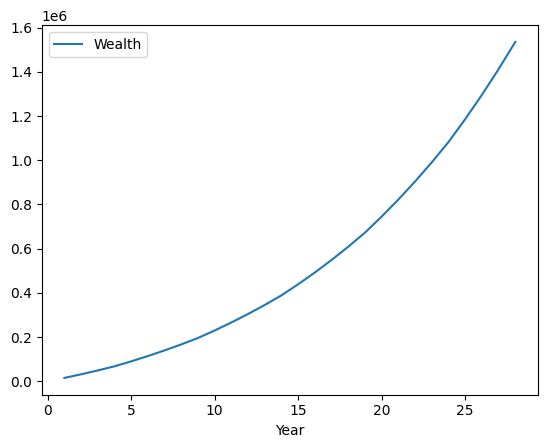

In [ ]:
df.plot.line(x='Year', y='Wealth')

<Axes: xlabel='Year'>

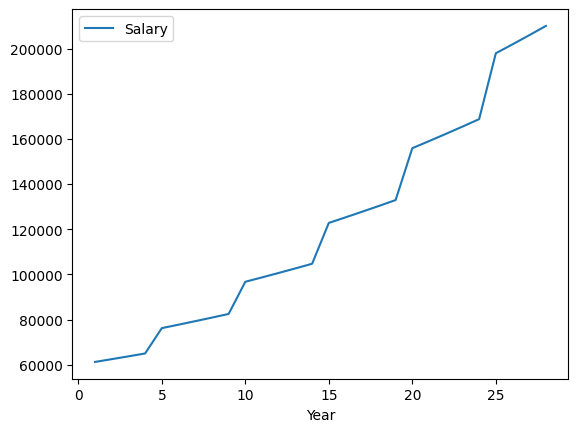

In [ ]:
df.plot.line(x='Year', y='Salary')

In [ ]:
def years_to_retirement_separate_args(
    starting_salary=60000, promos_every_n_years=5, cost_of_living_raise=0.02, 
    promo_raise=0.15, savings_rate=0.25, interest_rate=0.05, desired_cash=1500000
):
    data = ModelInputs(
        starting_salary=starting_salary, 
        promos_every_n_years=promos_every_n_years, 
        cost_of_living_raise=cost_of_living_raise, 
        promo_raise=promo_raise, 
        savings_rate=savings_rate, 
        interest_rate=interest_rate, 
        desired_cash=desired_cash
    )
    
    return years_to_retirement(data, print_output=False)

years_to_retirement_separate_args()

28

In [ ]:
sensitivity_values = {
    'starting_salary': [i * 10000 for i in range(4, 8)],
    'promos_every_n_years': [i for i in range(4, 8)],
    'cost_of_living_raise': [i/100 for i in range(1, 4)],
    'promo_raise': [i/100 for i in range(10, 25, 5)],
    'savings_rate': [i/100 for i in range(10, 50, 10)],
    'interest_rate': [i/100 for i in range(3, 8)],
    'desired_cash': [i * 100000 for i in range(10, 26, 5)]
}

In [ ]:
sa = SensitivityAnalyzer(
    sensitivity_values,
    years_to_retirement_separate_args,
    result_name='Years to Retirement',
    reverse_colors=True,
    grid_size=3
)

100%|██████████| 11520/11520 [00:06<00:00, 1661.35it/s]


In [ ]:
sa.df

,starting_salary,promos_every_n_years,cost_of_living_raise,promo_raise,savings_rate,interest_rate,desired_cash,Years to Retirement
0,40000,4,0.01,0.1,0.1,0.03,1000000,52
1,40000,4,0.01,0.1,0.1,0.03,1500000,60
2,40000,4,0.01,0.1,0.1,0.03,2000000,66
3,40000,4,0.01,0.1,0.1,0.03,2500000,71
4,40000,4,0.01,0.1,0.1,0.04,1000000,47
...,...,...,...,...,...,...,...,...
11515,70000,7,0.03,0.2,0.4,0.06,2500000,25
11516,70000,7,0.03,0.2,0.4,0.07,1000000,16
11517,70000,7,0.03,0.2,0.4,0.07,1500000,19
11518,70000,7,0.03,0.2,0.4,0.07,2000000,22


In [ ]:
bad_economy_data = ModelInputs(
    starting_salary=40000,
    promos_every_n_years=8,
    cost_of_living_raise=0.01,
    promo_raise=0.07,
    savings_rate=0.15,
    interest_rate=0.03,
)

good_economy_data = ModelInputs(
    starting_salary=70000,
    promos_every_n_years=4,
    cost_of_living_raise=0.03,
    promo_raise=0.20,
    savings_rate=0.35,
    interest_rate=0.06,
)

cases = {
    'Bad': bad_economy_data,
    'Normal': model_data, # Original inputs were set to assume a normal economy
    'Good': good_economy_data
}

In [ ]:
case_probabilities = {
    'Bad': 0.2,
    'Normal': 0.5,
    'Good': 0.3
}

# Take expected value over the cases
expected_ytr = 0
for case_type, case_inputs in cases.items():
    ytr = years_to_retirement(case_inputs, print_output=False)
    weighted_ytr = ytr * case_probabilities[case_type]
    expected_ytr += weighted_ytr
print(f'It would take {expected_ytr:.0f} years to retire considering a {case_probabilities["Bad"]:.0%} chance of a bad economy and {case_probabilities["Good"]:.0%} chance of a good economy.')

It would take 32 years to retire considering a 20% chance of a bad economy and 30% chance of a good economy.


# Evaluation

In [ ]:
list(portfolio.columns)

['AAPL',
 'NVDA',
 'ORCL',
 'MSFT',
 'GOOGL',
 'META',
 'AMZN',
 'TM',
 'VTI',
 'IVV',
 'VOO',
 'VGT',
 'VUG',
 'XLK']

In [ ]:
port_data = {}
start_date = '2023-12-31'
end_date = '2024-11-26'

for ticker in portfolio.columns:
    print(f"Fetching data for ticker: {ticker}")
    port_data[ticker] = yfinance_adj_close(ticker, start=start_date, end=end_date)

portfolio_df = pd.concat(port_data.values(), axis=1)
portfolio_df.ffill(inplace=True)
portfolio_df.bfill(inplace=True)
portfolio_df.columns = portfolio.columns
portfolio_df

Fetching data for ticker: AAPL
Fetching data for ['AAPL'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching data for ticker: NVDA
Fetching data for ['NVDA'] from 2023-12-31 to 2024-11-26 with interval '1d'
Fetching data for ticker: ORCL
Fetching data for ['ORCL'] from 2023-12-31 to 2024-11-26 with interval '1d'
Fetching data for ticker: MSFT
Fetching data for ['MSFT'] from 2023-12-31 to 2024-11-26 with interval '1d'
Fetching data for ticker: GOOGL
Fetching data for ['GOOGL'] from 2023-12-31 to 2024-11-26 with interval '1d'
Fetching data for ticker: META
Fetching data for ['META'] from 2023-12-31 to 2024-11-26 with interval '1d'
Fetching data for ticker: AMZN
Fetching data for ['AMZN'] from 2023-12-31 to 2024-11-26 with interval '1d'
Fetching data for ticker: TM
Fetching data for ['TM'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching data for ticker: VTI
Fetching data for ['VTI'] from 2023-12-31 to 2024-11-26 with interval '1d'
Fetching data for ticker: IVV
Fetching data for ['IVV'] from 2023-12-31 to 2024-11-26 with interval '1d'
Fetching data for ticker: VOO
Fetching data for ['VOO'] from 2023-12-31 to 2024-11-26 with interval '1d'
Fetching data for ticker: VGT
Fetching data for ['VGT'] from 2023-12-31 to 2024-11-26 with interval '1d'
Fetching data for ticker: VUG
Fetching data for ['VUG'] from 2023-12-31 to 2024-11-26 with interval '1d'
Fetching data for ticker: XLK
Fetching data for ['XLK'] from 2023-12-31 to 2024-11-26 with interval '1d'


Ticker,AAPL,NVDA,ORCL,MSFT,GOOGL,META,AMZN,TM,VTI,IVV,VOO,VGT,VUG,XLK
Date,,,,,,,,,,,,,,
2024-01-02,184.734985,48.157665,102.802834,368.117279,137.828705,345.250488,149.929993,181.369995,233.255447,470.135803,429.748047,468.817902,304.436798,186.468323
2024-01-03,183.351761,47.558796,101.222153,367.849243,138.576859,343.435944,148.470001,181.550003,231.018204,466.294647,426.559631,462.541016,301.358368,184.568237
2024-01-04,181.023163,47.987705,101.350586,365.208984,136.053101,346.078003,144.570007,182.970001,230.424255,464.859192,425.213013,459.755676,299.923737,183.215286
2024-01-05,180.296722,49.086464,101.488899,365.020386,135.394745,350.893524,145.240005,187.070007,230.770721,465.413574,425.757599,459.865143,300.262512,183.165527
2024-01-08,184.655365,52.241787,103.395584,371.908936,138.497055,357.583374,149.100006,187.889999,234.067169,471.818756,431.847260,471.573364,306.598694,187.761597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-19,228.279999,147.009995,188.899994,416.955414,178.119995,561.090027,204.610001,175.389999,292.829987,593.169983,542.700012,612.169983,403.790009,231.330002
2024-11-20,229.000000,145.889999,190.750000,414.659973,175.979996,565.520020,202.880005,172.910004,293.000000,593.440002,542.900024,612.820007,403.470001,231.130005
2024-11-21,228.520004,146.669998,192.429993,412.869995,167.630005,563.090027,198.380005,173.380005,295.049988,596.479980,545.640015,619.280029,403.950012,233.479996


In [ ]:
returns_df = portfolio_df.pct_change().dropna()
port_retss = returns_df.sum(axis=1)

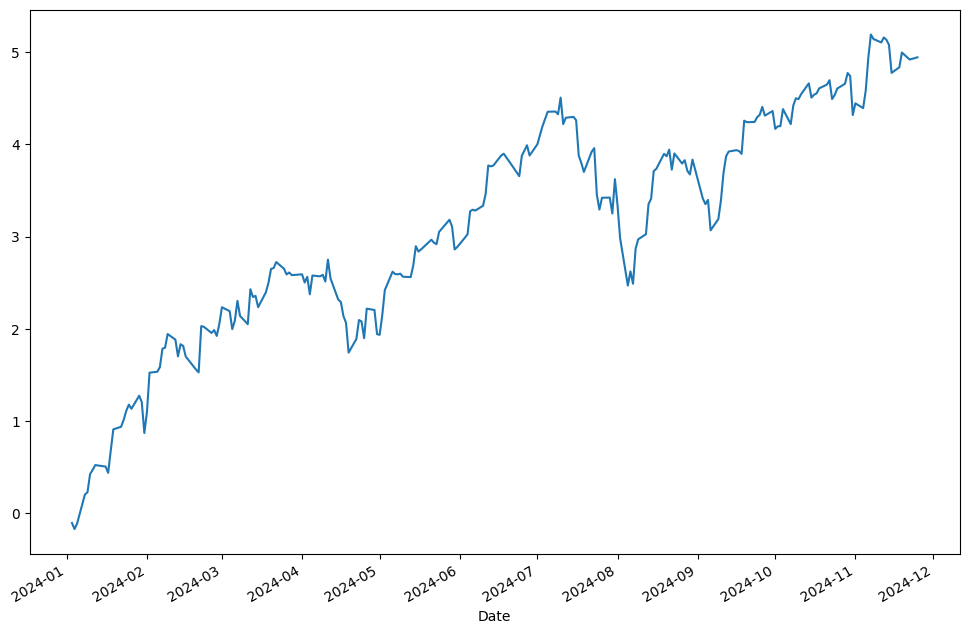

In [ ]:
port_retss.cumsum().plot(figsize=(12,8));

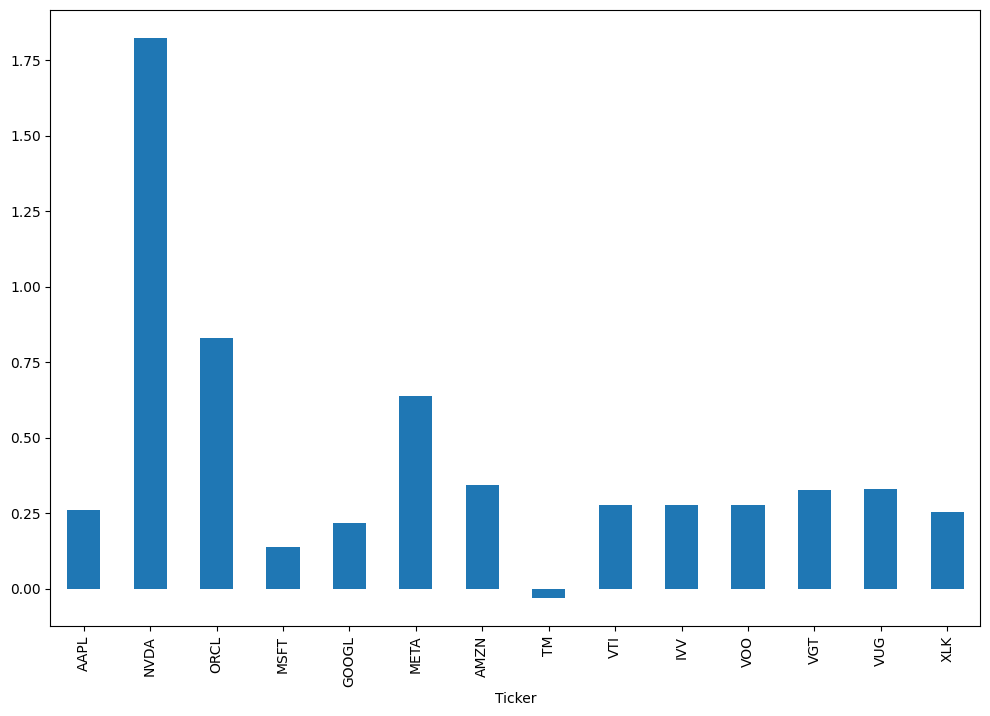

In [ ]:
cumulative_returns_df = (1 + returns_df).prod() - 1
cumulative_returns_df.plot(kind='bar', figsize=(12,8));

In [ ]:
ticker = "^IRX"

start_date = "2022-01-01"
end_date = "2024-11-26"

rf = yf.download(ticker, start=start_date, end=end_date)
rf = rf[['Adj Close']]
rf = rf.rename(columns={'Adj Close': 'rf'})
rolling_rf = rf.rolling(window=252).mean()
rolling_rf

[*********************100%***********************]  1 of 1 completed


Price,rf
Ticker,^IRX
Date,
2022-01-03,NaN
2022-01-04,NaN
2022-01-05,NaN
2022-01-06,NaN
2022-01-07,NaN
...,...
2024-11-19,5.058925
2024-11-20,5.055639


In [ ]:
rolling_rf.iloc[-1].values

array([5.0455595])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Portfolio Performance Metrics:
Annualized Sharpe Ratio: 2.00
Annualized Jensen Alpha: 4.60%

Attribution Analysis:
Allocation Effects: 0.18%
Selection Effects: 44.53%


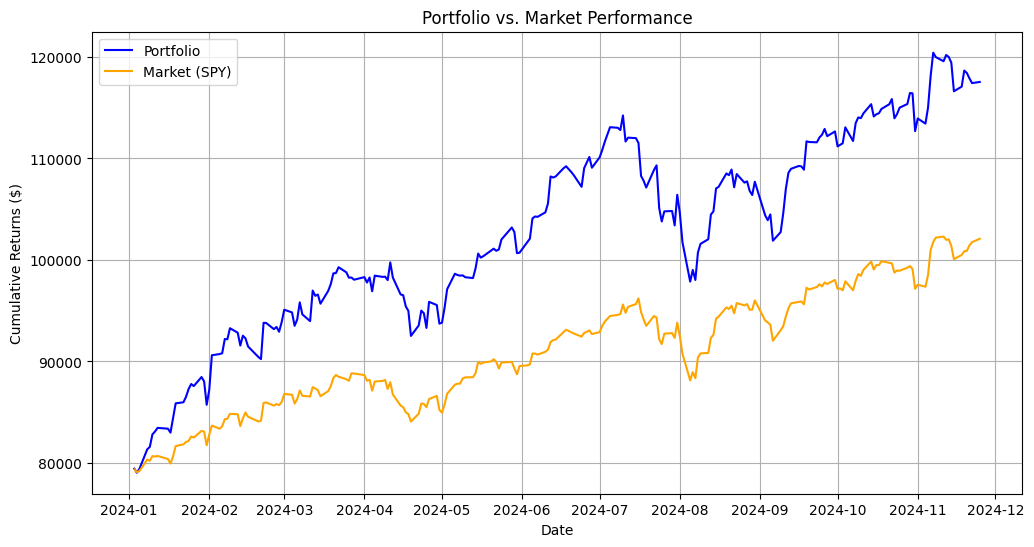

In [ ]:
start_date = '2023-12-31'
end_date = '2024-11-26'
# Market data (e.g., S&P 500 as market benchmark)
market_prices = yf.download("SPY", start=start_date, end=end_date)["Adj Close"]

# Fetch market data (S&P 500 as benchmark, SPY ETF)
market_prices = yf.download("SPY", start=start_date, end=end_date)["Adj Close"]

# Portfolio returns calculation (weighted daily returns based on portfolio_df and stock_weights)
# Calculate daily portfolio returns (percent change)
returns_df = portfolio_df.pct_change().dropna()  # Ensure no missing data
port_retss = (returns_df @ stock_weights).dropna()  # Weighted daily returns

# Align the market returns with the portfolio returns (by the same date index)
market_returns = market_prices.pct_change().dropna()

# Ensure both returns are aligned by the same index (dates)
aligned_returns = pd.concat([market_returns, port_retss], axis=1).dropna()
market_returns = aligned_returns.iloc[:, 0]
port_retss = aligned_returns.iloc[:, 1]

# Initial investment amount
initial_money = 80000

# Constants
trading_days_per_year = 252
risk_free_rate_annual = (rolling_rf.iloc[-1].values) / 100  # Risk-free rate

# Step 1: Calculate cumulative portfolio returns starting from initial investment
portfolio_cum_returns = (1 + port_retss).cumprod() * initial_money

# Step 2: Calculate market returns (cumulative returns of the SPY ETF)
market_cum_returns = (1 + market_returns).cumprod() * initial_money

# Step 3: Sharpe Ratio (Annualized)
risk_free_rate_daily = risk_free_rate_annual / trading_days_per_year
excess_returns = port_retss - risk_free_rate_daily
sharpe_ratio = (excess_returns.mean() * trading_days_per_year) / (port_retss.std() * np.sqrt(trading_days_per_year))

# Step 4: Jensen's Alpha (Annualized)
slope, intercept, _, _, _ = linregress(market_returns, port_retss)
jensen_alpha_daily = intercept
jensen_alpha = jensen_alpha_daily * trading_days_per_year

# Step 5: Attribution Analysis
allocation_effects = returns_df.mean() * stock_weights
selection_effects = port_retss.mean() * trading_days_per_year - allocation_effects.sum()

# Display Results
print("Portfolio Performance Metrics:")
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Annualized Jensen Alpha: {jensen_alpha:.2%}")

print("\nAttribution Analysis:")
print(f"Allocation Effects: {allocation_effects.sum():.2%}")
print(f"Selection Effects: {selection_effects:.2%}")

# Step 6: Plot Portfolio vs. Market
plt.figure(figsize=(12, 6))
plt.plot(portfolio_cum_returns, label="Portfolio", color="blue")
plt.plot(market_cum_returns, label="Market (SPY)", color="orange")  # Adjusted market cumulative returns
plt.legend()
plt.title("Portfolio vs. Market Performance")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns ($)")
plt.grid()
plt.show()

In [ ]:
beta, _, _, _, _ = linregress(market_returns, port_retss)
print(f"Beta: {beta:.2f}")

Beta: 1.44


In [ ]:
rolling_max = portfolio_cum_returns.cummax()
drawdown = (portfolio_cum_returns - rolling_max) / rolling_max
max_drawdown = drawdown.min()
print(f"Maximum Drawdown: {max_drawdown:.2%}")

Maximum Drawdown: -14.34%


In [ ]:
downside_returns = port_retss[port_retss < 0]
sortino_ratio = excess_returns.mean() / downside_returns.std()
print(f"Sortino Ratio: {sortino_ratio:.2f}")

Sortino Ratio: 0.18


In [ ]:
annualized_return = (portfolio_cum_returns.iloc[-1] / portfolio_cum_returns.iloc[0]) ** (252 / len(portfolio_returns)) - 1
print(f"Annualized Return: {annualized_return:.2%}")

Annualized Return: 8.17%


In [ ]:
correlation = port_retss.corr(market_returns)
print(f"Correlation with Market: {correlation:.2f}")

Correlation with Market: 0.90


In [ ]:
portfolio_volatility = port_retss.std() * (252 ** 0.5)  # Annualized volatility
print(f"Portfolio Volatility: {portfolio_volatility:.2%}")

Portfolio Volatility: 19.86%


In [ ]:
treynor_ratio = excess_returns.mean() / beta
print(f"Treynor Ratio: {treynor_ratio:.2f}")

Treynor Ratio: 0.00


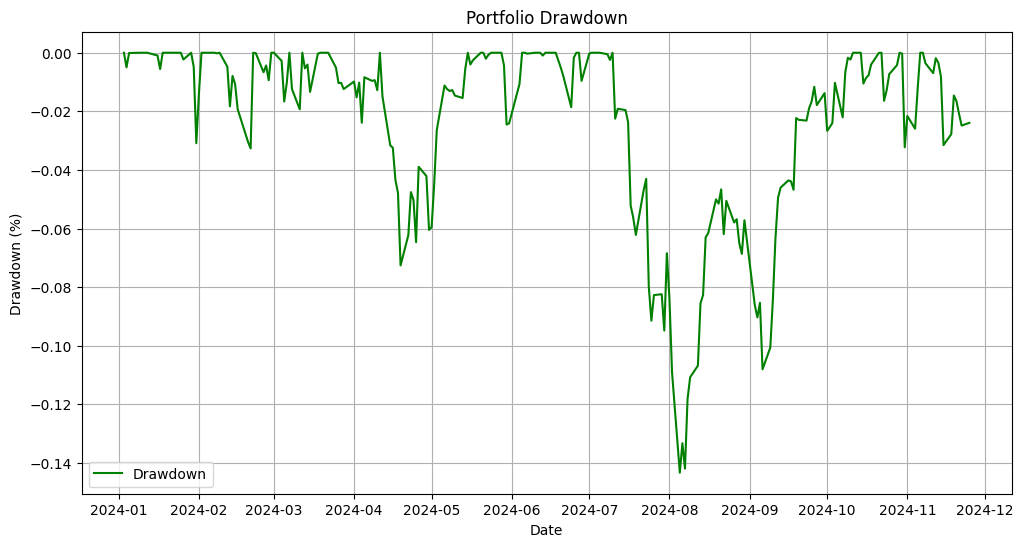

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(drawdown, label="Drawdown", color="green")
plt.title("Portfolio Drawdown")
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.grid()
plt.legend()
plt.show()